<a href="https://colab.research.google.com/github/Shai670/Residential_consumption_modeling/blob/main/Battery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import clear_output 

import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/Shai670/Residential_consumption_modeling
clear_output()

In [59]:
pv = pd.read_csv('/content/Residential_consumption_modeling/DATA/Kemerovo_2022_solcast_3.csv', index_col='time')
pv.index = pd.date_range(start='2022-01-01 07:00:00', freq='5MIN', periods=len(pv))
pv

,Solar
2022-01-01 07:00:00,-0.1
2022-01-01 07:05:00,-0.1
2022-01-01 07:10:00,-0.1
2022-01-01 07:15:00,-0.1
2022-01-01 07:20:00,-0.1
...,...
2023-01-01 06:35:00,-0.1
2023-01-01 06:40:00,-0.1
2023-01-01 06:45:00,-0.1
2023-01-01 06:50:00,-0.1


In [60]:
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]) 
use_time = np.array([0, 5, 10, 15, 30, 45, 60, 120, 240]) # в минутах

# вероятности включения для 1-го класса электроприборов
class1_N = 5 
class1_power = (0.12,2.2) # min,max мощность
class1_sessions = 2 # max кол-во включений в день
class1_switch = np.array([0, 0, 0, 0, 5, 10, 25, 20, 0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0]) 
class1_switch = class1_switch / np.sum(class1_switch) 

class1_tou = np.array([15, 25, 25, 15, 15, 15,  25, 0,  0]) 
class1_tou = class1_tou / np.sum(class1_tou) 

# вероятности включения для 2-го класса электроприборов
class2_N = 8 
class2_power = (0.06,2.2)
class2_sessions = 3
class2_switch = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 40, 50, 49, 35, 20, 0, 0]) 
class2_switch = class2_switch / np.sum(class2_switch) 

class2_tou = np.array([15, 15, 15, 15, 15, 25,  25, 25,  25]) 
class2_tou = class2_tou / np.sum(class2_tou) 

# вероятности включения для 3-го класса электроприборов
class3_N = 1
class3_power = (0.6,0.6)
class3_sessions = 4
class3_switch = np.array([5, 5, 0, 0, 0,10, 0, 10, 0, 10, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0,0 , 0, 0, 10]) 
class3_switch = class3_switch / np.sum(class3_switch) 

class3_tou = np.array([15, 15, 15, 15, 15, 15,  15, 15,  15]) 
class3_tou = class3_tou / np.sum(class3_tou)

In [61]:
class Pribor:
  """
  Пример класса для электроприбора
  """

  def __init__(self, power, switch_time, use_time):
    self.power = power # номинальная мощность электроприбора
    self.turn_on = switch_time * 60 + np.random.randint(0,59) # время включения в минутах
    self.turn_off = self.turn_on + use_time # время отключения в минутах

    self.sessions = len(switch_time) # кол-во включений за день

    self.state = 0 # текущее состосния (вкл=1, откл=0)

In [62]:
def add_eq(obj_list, N, power, sessions, switch_proba, tou_proba):

    ses = [np.random.randint(0, sessions) for _ in range(N)]

    eqs = [
        Pribor(
            power = np.random.uniform(power[0], power[1]),
            switch_time = np.random.choice(time, size=ses[i], p=switch_proba),
            use_time = np.random.choice(use_time, size=ses[i], p=tou_proba),
            )
        for i in range(N)
    ]

    obj_list += eqs

    return obj_list

In [63]:
profile_dataset = []

for _ in range(365):

    obj_list = []
    obj_list = add_eq(obj_list, N=class1_N, power=class1_power, sessions=class1_sessions, switch_proba=class1_switch, tou_proba=class1_tou)
    obj_list = add_eq(obj_list, N=class2_N, power=class2_power, sessions=class2_sessions, switch_proba=class2_switch, tou_proba=class2_tou)
    obj_list = add_eq(obj_list, N=class3_N, power=class3_power, sessions=class3_sessions, switch_proba=class3_switch, tou_proba=class3_tou)

    electric_load = []

    for dt in range(24*60): # шаг моделирования - 15 мин
      power_dt = 0 # обнуляем переменную мощности данного шага моделирования
      for eq in obj_list: # для каждого электроприбора 
        for s in range(eq.sessions): # перебрать все включения электроприбора за день
          if eq.turn_on[s] == dt: # если время включения равно текущему времени моделирования,
            eq.state = 1 # то включить прибор
          if eq.turn_off[s] == dt: # если время отключения равно текущему времени моделирования,
            eq.state = 0 # то отключить прибор
        if eq.state == 1: # если электроприбора включен, то
          power_dt += eq.power # увеличить потребляемую мощность на мощность включенного электроприбора
      electric_load.append(power_dt)

    profile_dataset.append(electric_load)

In [64]:
load = pd.DataFrame(np.array(profile_dataset).reshape(365*1440,), columns=['load'], index=pd.date_range(start=pv.index[0], periods=525600, freq='MIN'))
load

,load
2022-01-01 07:00:00,0.000000
2022-01-01 07:01:00,0.000000
2022-01-01 07:02:00,0.000000
2022-01-01 07:03:00,0.000000
2022-01-01 07:04:00,0.000000
...,...
2023-01-01 06:55:00,0.922316
2023-01-01 06:56:00,0.922316
2023-01-01 06:57:00,0.922316
2023-01-01 06:58:00,0.922316


In [65]:
class battery:
  

  def __init__(self, Pnom, capacity):
    self.Pnom = Pnom # номинальная мощность батареи
    self.capacity = capacity # ёмкость Вт*ч
    
    self.SOC_min = 20
    self.SOC_max = 85
    self.SOC = self.SOC_min

    #self.capacity_fact = self.SOC/100 * self.capacity

  def working (self, Pgen, Pload):
     Pbat = 0

     if Pgen > Pload:
       if self.SOC <= self.SOC_max:
         if (Pgen - Pload) >= self.Pnom:
           Pbat = self.Pnom 
         elif (Pgen - Pload) < self.Pnom:
           Pbat = Pgen - Pload

     else: 
       if self.SOC >= self.SOC_min: 
         if Pload - Pgen >= self.Pnom:
           Pbat = -self.Pnom 
         elif Pload - Pgen < self.Pnom:
           Pbat = -(Pload-Pgen)

     self.SOC += 1/60 * Pbat / self.capacity

     # self.capacity_fact += 1/60 * Pbat
     # self.SOC = self.capacity_fact / self.capacity * 100
    
     return Pbat
                

In [66]:
dataset = pd.merge(load, pv, left_index=True, right_index=True, how='outer').dropna()
dataset[dataset['Solar'] < 0] = 0
dataset['Solar'] *= 1e-3
dataset

,load,Solar
2022-01-01 07:00:00,0.0,0.0
2022-01-01 07:05:00,0.0,0.0
2022-01-01 07:10:00,0.0,0.0
2022-01-01 07:15:00,0.0,0.0
2022-01-01 07:20:00,0.0,0.0
...,...,...
2023-01-01 06:35:00,0.0,0.0
2023-01-01 06:40:00,0.0,0.0
2023-01-01 06:45:00,0.0,0.0
2023-01-01 06:50:00,0.0,0.0


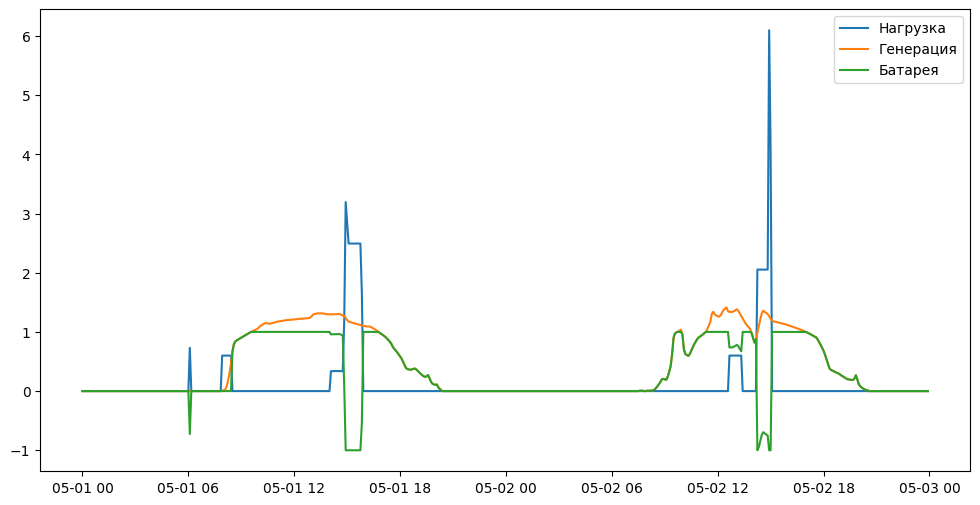

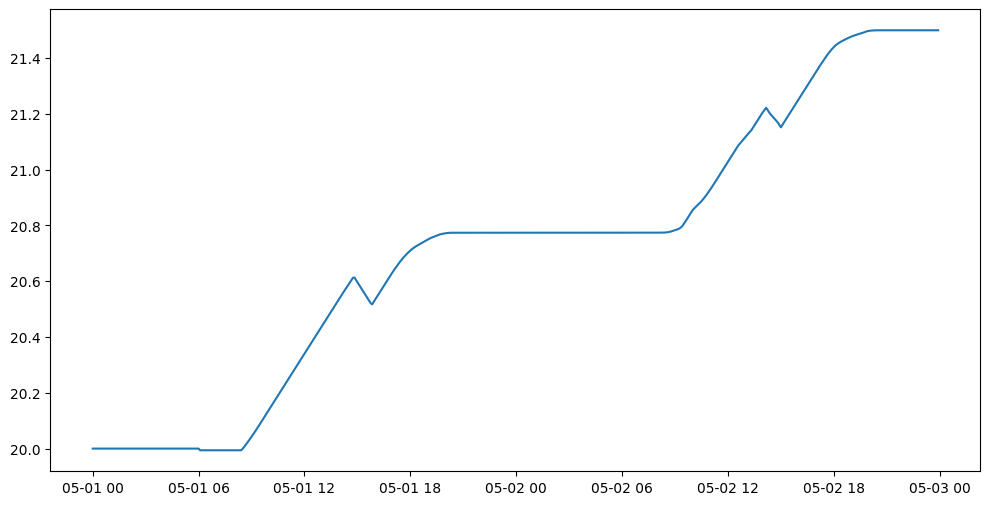

In [88]:
bat = battery(Pnom=1, capacity=2)

load_data = dataset['load'].loc['2022-05-01' : '2022-05-02']
gen_data  = dataset['Solar'].loc['2022-05-01' : '2022-05-02']

Pbat = []; soc = []
for load, gen in zip(load_data, gen_data):
  Pbat.append(bat.working(Pgen=gen, Pload=load))
  soc.append(bat.SOC)

Pbat = pd.DataFrame({'bat' : Pbat}, index=load_data.index)
soc = pd.DataFrame({'soc' : soc}, index=load_data.index)

plt.figure(figsize=(12,6))
plt.plot(load_data, label='Нагрузка')
plt.plot(gen_data, label='Генерация')
plt.plot(Pbat, label='Батарея')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(soc, label='Нагрузка')
plt.show()